# ５．ベイズ最適化ハンズオン

## はじめに

ベイズ最適化の流れは以下の通りです。

<img src="./data/bayesian.png" width="600"> 

## 問題設定　～1次元のベイズ最適化～

普段皆さんは多数の説明変数と目的変数を入出力する実験装置を使用されていると思います。今回は問題を単純化するために、1種類の説明変数を入力すると1種類の目的変数が出力される実験装置を仮定します。  
今回の目的は、**単回帰分析**です。ただし、前編の回帰と異なる点は、**最初に多くのデータ数を必要としない**です。  
前編では多数のデータに潜むパターンを学習して得られたモデルを作成してきました。後半のベイズ最適化は、少ないデータから確実性を高めていくようにデータ点を増やしてモデルを作成します。  

ベイズ最適化の理論の理解には確率・統計などの数学の履修が必要ですが、まずは**使えること！**、使えるようになった後で理論を深めていく方針で、まずは使える手ごたえ感を実感していただきたいと思います。

# ライブラリのインポート

次のセルを実行してください。

In [1]:
%matplotlib notebook
import numpy as np #数値計算ライブラリ
import matplotlib.pyplot as plt #グラフ描画ライブラリ
from mpl_toolkits.mplot3d import Axes3D #3Dグラフ描画ライブラリ

from sklearn.gaussian_process import GaussianProcessRegressor #機械学習ライブラリ　ガウス過程回帰
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as Wh #機械学習ライブラリ カーネル
from sklearn.model_selection import train_test_split #機械学習ライブラリ データ分割

from sklearn.metrics import mean_absolute_error #機械学習ライブラリ 平均絶対誤差
from sklearn.metrics import mean_squared_error #機械学習ライブラリ 平均二乗誤差

from sklearn.preprocessing import StandardScaler #機械学習ライブラリ 標準正規化
from sklearn.preprocessing import MinMaxScaler #機械学習ライブラリ　最大最少正規化

import experiment as expel # 実験装置ライブラリ*オリジナル

np.set_printoptions(precision=2) #numpyの表示桁数指定
import random

# 注意

3D描画のために、%matplotlib notebookとしているので、グラフ表示後はグラフ右上の電源ボタンを押してください。以降のグラフも同じです。

## 初期サンプリング

初期データを"実験"から取得しましょう。  
初期データ数を`num = `に指定してコードを実行すると、その個数の目的変数が出力されます。今回の設定では、説明変数はランダムな入力値が入力されるようになっています。実際の実験では実験計画法などを用いて初期データを取得します。

[0.38 0.97 0.79 0.68 0.24]


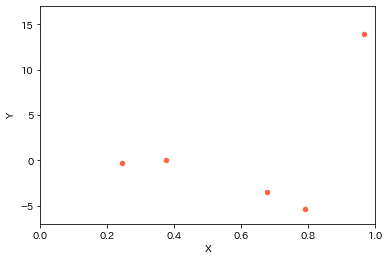

In [37]:
## 初期点作成
## 初期点数
num = 5

## 実験
# np.random.seed(seed=0) # ランダムシード
X = np.random.rand(num)
Y = expel.Experiment_1D(X)
print(X)

## 初期点可視化
plt.scatter(X, Y, color="tomato",s=20)
plt.xlim(0,1) #x軸の描画範囲
plt.ylim(-7,17) #x軸の描画範囲
plt.xlabel("X") #x軸ラベル
plt.ylabel("Y") #y軸ラベル
plt.show()

## ガウス過程回帰

取得したデータを使ってモデルを予測します。  
取得済データ周辺と未取得データ周辺の類似度（不確実性）を測るために使われるカーネル関数、これのハイパーパラメータを調整します。調整したカーネル関数を用いて取得データから回帰します。

In [38]:
## カーネル関数のハイパーパラメータ調整

## C：振幅 (constant_value初期値、constant_value範囲)
## RBF：波長（length_scale初期値、length_scale範囲）
## Wh：ノイズ (noise_level初期値、noise_level範囲)

kernel = C(1.0, (1e-2,1e2)) * RBF(1.0, (1e-2,1e-1)) + Wh(0.01, (1e-2,1e2))
reg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)


## 回帰
reg.fit(X.reshape(-1,1), Y.reshape(-1,1)) 

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=30, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

回帰したデータを可視化します。

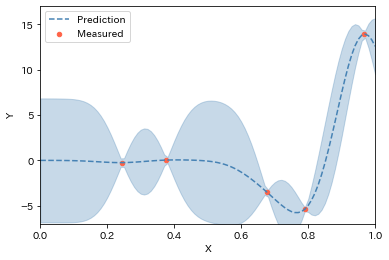

In [39]:
## 回帰結果のプロット

X_pred = np.linspace(0,1,101) 
Y_pred, Y_var = reg.predict(X_pred.reshape(-1,1), return_std=True) 

plt.plot(X_pred, Y_pred, linestyle="dashed", label="Prediction", color="steelblue")
plt.fill_between(X_pred, (Y_pred.reshape(-1)-Y_var), (Y_pred.reshape(-1)+Y_var), alpha=0.3, color="steelblue")

plt.scatter(X, Y, color="tomato", label="Measured",s=20)

plt.legend() 
plt.xlim(0,1) 
plt.ylim(-7,17) 
plt.xlabel("X") 
plt.ylabel("Y") 
plt.show()

データ点を通る点線のモデルですが、データ点以外は不確実度を青の領域として表現しています。  
ハイパーパラメータを調整することでこれらの不確実度の閾値を調整します。

## 最適化・最小値探索

上図から、不確実さを解消する「探索」、あるいは最適解（この場合最小値）付近を狙う「活用」、いずれかを判断して次に取得するデータを決定します。この方針を決定するのが獲得関数です。獲得関数は、「活用」と「探索」それぞれに重きを置いた手法がいくつか開発されています。  
今回は"Lower Confidence Bounds(LCB)"を選択し、ハイパーパラメータを調整して「活用」と「探索」のバランスをとります。

In [43]:
## ハイパーパラメータ設定
## 探索の強さalphaが小さいと「活用」に、alphaが大きいと「探索」に重きがおかれます
alpha = 1 
## 獲得関数の計算
Y_LCB = Y_pred.reshape(-1) - alpha*Y_var 

## 最適化
arg_min = np.argmin(Y_LCB) 
X_next = X_pred[arg_min] 
print("次の入力値： "+str(X_next))

次の入力値： 0.74


## 実験＆測定

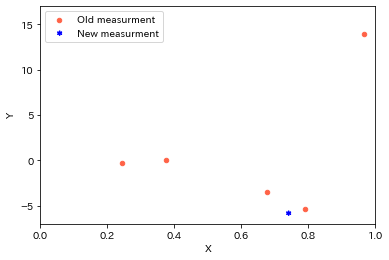

In [45]:
## 次の入力値を使って実験
Y_next = expel.Experiment_1D(X_next) 

## 次の測定点を可視化
plt.scatter(X, Y, color="tomato", label="Old measurment", s=20)
plt.scatter(X_next, Y_next, color="b", label="New measurment",marker="$*$",s=50)
plt.xlim(0,1) 
plt.ylim(-7,17) 
plt.xlabel("X") 
plt.ylabel("Y") 
plt.legend() 
plt.show()

In [7]:
## データ点の更新
X = np.concatenate((X, np.array([X_next])))
Y = np.concatenate((Y, np.array([Y_next])))

更新したデータを用いて再び回帰を行うために、「4 ガウス過程回帰」に戻ります。   
「4 ガウス過程回帰」～「6 実験＆測定」まで繰り返しましょう。

## 答え合わせ

予測曲線が大きく変動しないところまで「4 ガウス過程回帰」～「6 実験＆測定」を繰り返したら、以降を実行して答え合わせをしましょう。  

実験装置はあるルールに則って我々が設定する入力値に対する出力を返します。今回の問題も裏である関数を設定し、"実験"として入力値に対する出力値を返していました。  
初期サンプリングのデータから上記のサイクルを繰り返すことで設定した関数にどれだけ近づけるのか、それを"答え合わせ"したいと思います。

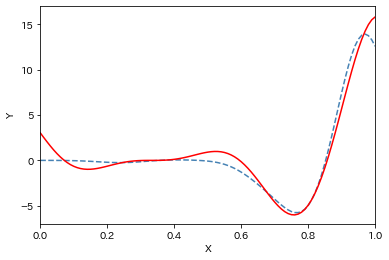

In [56]:
## 実験関数と予測関数の描画

X = np.linspace(0,1,101) 
Y_exp = expel.Experiment_1D(X) 

plt.plot(X, Y_pred, linestyle="dashed", label="Prediction", color="steelblue")
plt.plot(X, Y_exp, linestyle="solid", label="True", color="r")
plt.xlabel("X") 
plt.ylabel("Y") 
plt.xlim(0,1) 
plt.ylim(-7,17) 
plt.show()

目的に応じて、「活用」と「探索」を使い分けて（獲得関数の選択とそのハイパーパラメータの調整）少ない試行回数で解にたどりつくことが出来るかもしれません。

## 演習 
1. 初期値の数、初期値のランダムシードを変えて最適化してみましょう
2. ガウス過程回帰のハイパーパラメータ（C、RBF、White）を変えて、回帰結果がどのように変わるかを調べましょう
3. 最適化・最小値探索で獲得関数のハイパーパラメータを変えて、次の探索点がどのように提示されるのか確認しましょう

## Appendix：2次元のベイズ最適化

以下は2次元で同様にベイズ最適化を行うコードです。"実験関数"がテスト関数になっています。

In [59]:
## テスト関数
def test_func(x):
    y = (4-2.1*x[:,0]**2+x[:,0]**4/3)*x[:,0]**2+x[:,0]*x[:,1]+(-4+4*x[:,1]**2)*x[:,1]**2+0.5*x[:,1]
    return y

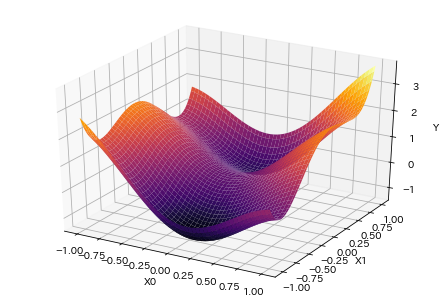

In [60]:
## テスト関数の3D描画
fig2 = plt.figure()
ax2 = Axes3D(fig2)

X0, X1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)) # メッシュグリッド作成
X = np.vstack((X0.reshape(-1), X1.reshape(-1))).T # vstackは行列の結合、Tは転置
Y = test_func(X).reshape(100,100) 
ax2.plot_surface(X0, X1, Y, cmap="inferno") # alphaで透明度を指定

ax2.set_xlabel("X0")
ax2.set_ylabel("X1")
ax2.set_zlabel("Y")

plt.show()

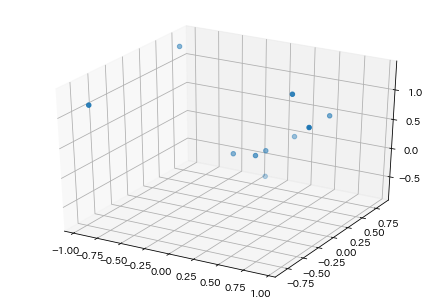

In [61]:
## 初期データ作成
data_num = 10 # 初期点数
noise = 0.2
np.random.seed(seed=0) # シード固定
x = np.random.rand(data_num,2)*2-1
y = test_func(x) + np.random.randn(data_num)*noise

## 3Dプロット
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(x[:,0], x[:,1], y) # 3D散布図
plt.show() # 図の描画

In [62]:
## データ分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

print("x_train:", x_train.shape, "   ", "x_val:", x_val.shape,"   ", "x_test:", x_test.shape)
print("y_train:", y_train.shape, "     ", "y_val:", y_val.shape,"     ", "y_test:", y_test.shape)

x_train: (6, 2)     x_val: (2, 2)     x_test: (2, 2)
y_train: (6,)       y_val: (2,)       y_test: (2,)


### まずはガウス過程回帰

In [63]:
## カーネル設定
## C(constant_value初期値、constant_value範囲)
## RBF（length_scale初期値、length_scale範囲）
## Wh(noise_level初期値、noise_level範囲)
kernel = C(1.0, (1, 3)) * RBF(1.0, (1e-2, 100)) + Wh(0.01, (0.01, 1))
reg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)

## 回帰
reg.fit(x_train, y_train)

## 誤差の計算
y_pred = reg.predict(x_train) # 各データ点のｙ予測値
y_pred_val = reg.predict(x_val) # 各データ点のｙ予測値
print("MAE train:", mean_absolute_error(y_train, y_pred)) # 平均絶対誤差
print("MAE val:", mean_absolute_error(y_val, y_pred_val)) # 平均絶対誤差
print("MSE train:", mean_squared_error(y_train, y_pred)) # 平均二乗誤差
print("MSE val:", mean_squared_error(y_val, y_pred_val)) # 平均二乗誤差

MAE train: 0.009191478751578141
MAE val: 0.5481332192945537
MSE train: 0.00010063709201405331
MSE val: 0.5247486122282621


### 演習
カーネルのハイパーパラメータの初期値や範囲を変えてガウス過程回帰を行い、誤差の変化を調べてみましょう。  
<br>  

### 回帰結果のプロット

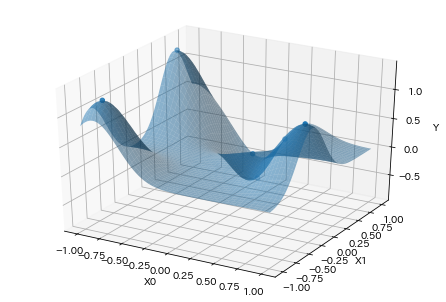

In [64]:
## Train 3Dプロット
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(x_train[:,0], x_train[:,1], y_train) # 3D散布図

X0, X1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)) # メッシュグリッド作成
X = np.vstack((X0.reshape(-1), X1.reshape(-1))).T # vstackは行列の結合、Tは転置
Y = reg.predict(X).reshape(100,100) # 予測
ax.plot_surface(X0, X1, Y, alpha = 0.5) # alphaで透明度を指定

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("Y")

plt.show()

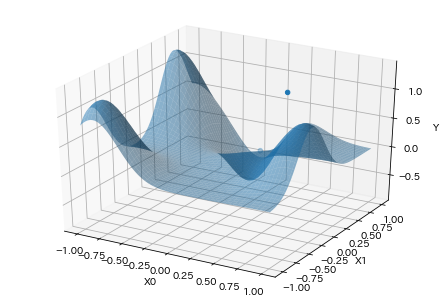

In [65]:
## Val 3Dプロット
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(x_val[:,0], x_val[:,1], y_val) # 3D散布図

X0, X1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)) # メッシュグリッド作成
X = np.vstack((X0.reshape(-1), X1.reshape(-1))).T # vstackは行列の結合、Tは転置
Y = reg.predict(X).reshape(100,100) # 予測
ax.plot_surface(X0, X1, Y, alpha = 0.5) # alphaで透明度を指定

ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("Y")

plt.show()

### 予測分散

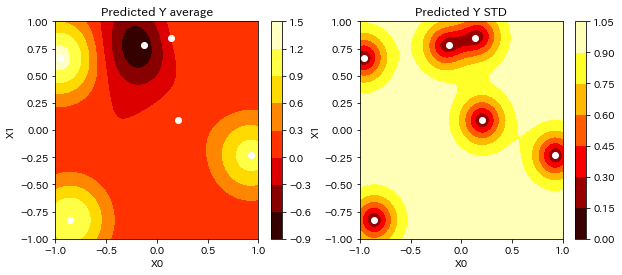

In [66]:
%matplotlib inline
X0, X1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)) # メッシュグリッド作成
X = np.vstack((X0.reshape(-1), X1.reshape(-1))).T # vstackは行列の結合、Tは転置
Y, Y_std = reg.predict(X, return_std=True) # 予測

plt.figure(figsize=(10,4)) # 図のサイズ設定

plt.subplot(1,2,1)
map1 = plt.contourf(X0, X1, Y.reshape(100,100), cmap="hot") # カラーマップ
plt.scatter(x_train[:,0], x_train[:,1], c="w")
plt.title("Predicted Y average")
plt.xlabel("X0")
plt.ylabel("X1")
plt.colorbar(map1)

plt.subplot(1,2,2)
map2 = plt.contourf(X0, X1, Y_std.reshape(100,100), cmap="hot") # カラーマップ
plt.scatter(x_train[:,0], x_train[:,1], c="w")
plt.title("Predicted Y STD")
plt.xlabel("X0")
plt.ylabel("X1")
plt.colorbar(map2)

plt.show()

# ここから逐次最適化

### 初期サンプリング

In [67]:
## サンプリング
def sampling(x, noise):
    return test_func(x) + np.random.randn()*noise

In [68]:
## 初期5点をランダムサンプリング
data_num = 5
noise = 0.2
np.random.seed(seed=0) # シード固定
x = np.random.rand(data_num,2)*2-1 # 平均0付近で-1~1までのデータを生成
y = sampling(x, noise)
print(x)

[[ 0.1   0.43]
 [ 0.21  0.09]
 [-0.15  0.29]
 [-0.12  0.78]
 [ 0.93 -0.23]]


### ガウス過程回帰

In [69]:
## ガウス過程回帰
kernel = C(1.0, (1e-3, 1e3)) * RBF([1.0,1.0], (3e-1, 1e2)) + Wh(0.2, (1e-05, 1))
reg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
reg.fit(x, y)
y_pred = reg.predict(x,return_std=False)


print("MSE val:", mean_squared_error(y, y_pred)) # 平均二乗誤差

MSE val: 1.4902383051238436e-09


### 結果のプロット

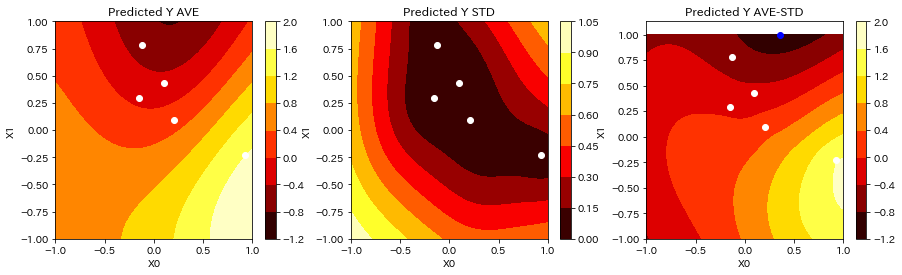

In [70]:
## 表示
X0, X1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)) # メッシュグリッド作成
X = np.vstack((X0.reshape(-1), X1.reshape(-1))).T # vstackは行列の結合、Tは転置
Y, Y_std = reg.predict(X, return_std=True) # 予測

plt.figure(figsize=(15,4)) # 図のサイズ設定

plt.subplot(1,3,1)
map1 = plt.contourf(X0, X1, Y.reshape(100,100), cmap="hot") # カラーマップ
plt.scatter(x[:,0], x[:,1], c="w")
plt.title("Predicted Y AVE")
plt.xlabel("X0")
plt.ylabel("X1")
plt.colorbar(map1)

plt.subplot(1,3,2)
map2 = plt.contourf(X0, X1, Y_std.reshape(100,100), cmap="hot") # カラーマップ
plt.scatter(x[:,0], x[:,1], c="w")
plt.title("Predicted Y STD")
plt.xlabel("X0")
plt.ylabel("X1")
plt.colorbar(map2)

plt.subplot(1,3,3)
map2 = plt.contourf(X0, X1, (Y-Y_std).reshape(100,100), cmap="hot") #カラーマップ
plt.scatter(x[:,0], x[:,1], c="w")
idx = np.argmin(Y-Y_std) # 獲得関数最小のインデックス
plt.scatter(X[idx,0], X[idx,1], c="b") # 獲得関数最小の座標
plt.title("Predicted Y AVE-STD")
plt.xlabel("X0")
plt.ylabel("X1")
plt.colorbar(map2)

plt.show()

### 測定とデータ追加

In [71]:
## 測定
Y_next = sampling(X[idx].reshape(1,2), noise)
print(X[idx])

## データ追加
x = np.concatenate((x, X[idx].reshape(1,2)))
y = np.concatenate((y, Y_next))

[0.35 1.  ]


### ガウス過程回帰に戻る

### 演習
初期サンプリングデータ、カーネルのハイパーパラメータの初期値や範囲を変えてベイズ最適化を行い最小値を見つけるのに必要な測定点数を比較してみましょう。